# aC helix descriptors

This notebook aims to identify descriptors of aC helix conformations that can be used to bias SAMS simulations. The [KLIFS database](https://klifs.net/index.php) will be queried for available kinase structures and analyzed for 5 distances connecting C alpha atoms of the aC helix and the hinge region. These distances were picked, since the hinge region is enclosed in the ATP binding pocket and may be stable enough to pull the aC helix closer to the ATP pocket without altering the overall structure of the kinase (aC helix out -> in). Finally, mean and standard deviations of these distances are calculated that are the basis for adding bias to SAMS simulations.

In [1]:
import pathlib

from appdirs import user_cache_dir
import MDAnalysis as mda
from opencadd.databases.klifs import setup_remote
from openeye import oechem
import pandas as pd
from tqdm import tqdm

INFO:opencadd.databases.klifs.api:If you want to see an non-truncated version of the DataFrames in this module, use `pd.set_option('display.max_columns', 50)` in your notebook.


In [2]:
# Set up remote session
remote = setup_remote()

INFO:opencadd.databases.klifs.api:Set up remote session...
INFO:opencadd.databases.klifs.api:Remote session is ready!


In [3]:
# retrieve kinase structures
kinase_df = remote.structures.all_structures()
# remove NMR structures
kinase_df = kinase_df[kinase_df["structure.resolution"].notna()]
print("Number of PDB entries:", len(set(kinase_df["structure.pdb_id"])))
print("Number of KLIFS entries:", len(kinase_df))

Number of PDB entries: 5420
Number of KLIFS entries: 11674


In [4]:
def klifs_to_pdb_resids(klifs_resids, klifs_structure_id):
    """
    Convert klifs pocket resids into the corresponding pdb resids of the 
    specified klifs structure.
    
    Parameters
    ----------
    klifs_resids: list of int
        KLIFS pocket residue ids.
    klifs_structure_id: int
        KLIFS structure ID of the structure to get the corresponding pdb resids for.
        
    Returns
    -------
    convert_dict: dict
        The dictionary with klifs resids as keys and pdb resids as values.
    """    
    pocket = remote.pockets.by_structure_klifs_id(klifs_structure_id)
    pdb_resids = pocket[pocket["residue.klifs_id"].isin(klifs_resids)]["residue.id"].to_list()
    convert_dict = {klifs_resid: int(pdb_resid) for klifs_resid, pdb_resid in zip(sorted(klifs_resids), pdb_resids) if pdb_resid != "_"}
    return convert_dict

In [5]:
def distance(x, y):
    """ This function returns the euclidean distance between two point in three dimensional space. """
    return ((x[0] - y[0]) ** 2 + (x[1] - y[1]) ** 2 + (x[2] - y[2]) ** 2) ** 0.5

Residues of the aC helix (20, 22, 24, 26, 28) and the hinge region (45, 46, 47, 48, 49) are conserved among all protein kinases and hence, should be applicable for SAMS simulations of most protein kinases of interest ([KLIFS residues](https://klifs.net/faq.php)).

In [6]:
critical_residues = [17, 20, 22, 24, 26, 28, 45, 46, 47, 48, 49]
critical_distances = ["17_24", "20_49", "22_48", "24_47", "26_46", "28_45"]
conformations = ["out", "out-like", "in"]

In [7]:
directory = pathlib.Path(user_cache_dir()) / "klifs_structures"
directory.mkdir(parents=True, exist_ok=True)
invalid_structures = {"missing_atoms": [], "non_unique_atoms": []}
distances = []
complete_df = kinase_df[(kinase_df["structure.dfg"] != "na") & 
                        (kinase_df["structure.ac_helix"] != "na")]
complete_df = complete_df[~complete_df["structure.pdb_id"].isin(["6pjx"])] # remove erroneous structures
for index, structure in tqdm(complete_df.iterrows(), total=complete_df.shape[0]):
    path = directory / f"{structure['structure.klifs_id']}.pdb"
    if not path.is_file():
        pdb_text = remote.coordinates.to_text(structure["structure.klifs_id"], 
                                              extension="pdb")
        with open(path, "w") as wf:
            wf.write(pdb_text)
    pdb_structure = mda.Universe(path, guess_masses=False)
    klifs_to_pdb_dict = klifs_to_pdb_resids(critical_residues, 
                                            structure["structure.klifs_id"])
    distances_tmp = []
    if len(klifs_to_pdb_dict) == len(critical_residues):
        for critical_distance in critical_distances:
            residue_pair = critical_distance.split("_")
            if "17" in critical_distance:
                coords1 = pdb_structure.select_atoms(
                    f"resid {klifs_to_pdb_dict[int(residue_pair[0])]} and name NZ").positions
                if len(coords1) == 0:
                    invalid_structures["missing_atoms"].append([structure['structure.klifs_id'], residue_pair[0]])
                    break
                elif len(coords1) == 1:
                    coords1 = coords1[0]
                else:
                    invalid_structures["non_unique_atoms"].append([structure['structure.klifs_id'], residue_pair[0]])
                    break
                coords2 = pdb_structure.select_atoms(
                    f"resid {klifs_to_pdb_dict[int(residue_pair[1])]} and (name OE1 or name OE2)").positions
                if len(coords2) < 2:
                    invalid_structures["missing_atoms"].append([structure['structure.klifs_id'], residue_pair[1]])
                    break
                elif len(coords2) == 2:
                    coords2 = coords2
                else:
                    invalid_structures["non_unique_atoms"].append([structure['structure.klifs_id'], residue_pair[1]])
                    break
                distances_tmp.append(min(distance(coords1, coords2[0]), distance(coords1, coords2[1])))
            else:
                coords1 = pdb_structure.select_atoms(
                    f"resid {klifs_to_pdb_dict[int(residue_pair[0])]} and name CA").positions
                if len(coords1) == 0:
                    invalid_structures["missing_atoms"].append([structure['structure.klifs_id'], residue_pair[0]])
                    break
                elif len(coords1) == 1:
                    coords1 = coords1[0]
                else:
                    invalid_structures["non_unique_atoms"].append([structure['structure.klifs_id'], residue_pair[0]])
                    break
                coords2 = pdb_structure.select_atoms(
                    f"resid {klifs_to_pdb_dict[int(residue_pair[1])]} and name CA").positions
                if len(coords2) == 0:
                    invalid_structures["missing_atoms"].append([structure['structure.klifs_id'], residue_pair[1]])
                    break
                elif len(coords2) == 1:
                    coords2 = coords2[0]
                else:
                    invalid_structures["non_unique_atoms"].append([structure['structure.klifs_id'], residue_pair[1]])
                    break
                distances_tmp.append(distance(coords1, coords2))
        if len(distances_tmp) == len(critical_distances):
            distances.append([structure['structure.klifs_id'], structure['structure.dfg'], structure['structure.ac_helix']] + distances_tmp)

  0%|          | 0/11321 [00:00<?, ?it/s]/home/david/miniconda3/envs/kinoml/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: MN
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
  4%|▍         | 473/11321 [01:52<38:06,  4.74it/s]  /home/david/miniconda3/envs/kinoml/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: AL
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
  5%|▍         | 525/11321 [02:03<38:56,  4.62it/s]/home/david/miniconda3/envs/kinoml/lib/python3.7/site-packages/MDAnalysis/topology/guessers.py:80: UserWarning: Failed to guess the mass for the following atom types: RU
  warnings.warn("Failed to guess the mass for the following atom types: {}".format(atom_type))
  5%|▌         | 581/11321 [02:20<39:54,  4.49it/s]  /home/d

In [33]:
distances_df = pd.DataFrame(distances, columns=["klifs_id", "dfg", "ac_helix"] + critical_distances)
distances_df.head()

,klifs_id,dfg,ac_helix,17_24,20_49,22_48,24_47,26_46,28_45
0,10881,in,in,3.089630,25.272524,22.241090,16.629157,16.249722,9.155457
1,2548,in,in,2.769974,24.815292,22.079558,16.559030,16.306088,9.325119
2,10431,in,in,3.320335,24.887775,21.952821,16.470332,16.214365,9.411622
3,9868,in,in,2.724588,25.696716,22.275710,17.013616,16.332138,9.592875
4,10435,in,in,2.612160,25.146516,22.098123,16.559644,16.316663,9.299524


In [46]:
ac_helix_statistics = []
for ac_helix_conformation in ["in", "out-like", "out"]:
    ac_helix_statistics.append(distances_df[distances_df["ac_helix"] == ac_helix_conformation][critical_distances].mean())
    ac_helix_statistics.append(distances_df[distances_df["ac_helix"] == ac_helix_conformation][critical_distances].std())
ac_helix_statistics = pd.DataFrame(ac_helix_statistics).T
ac_helix_statistics.columns = ["in_mean", "in_std", "out-like_mean", "out-like_std", "out_mean", "out_std"]
ac_helix_statistics

,in_mean,in_std,out-like_mean,out-like_std,out_mean,out_std
17_24,3.267508,1.198827,4.193753,2.704338,10.235203,5.412526
20_49,26.208993,2.110693,26.470004,1.479586,29.368592,2.204420
22_48,22.554301,1.021432,22.863814,1.309829,23.645853,1.234202
24_47,17.348483,0.766446,17.850519,1.014201,20.126625,1.932349
26_46,16.521078,0.729604,16.618977,1.090077,16.409163,1.296425
28_45,9.818745,0.583821,9.783362,0.692177,10.719205,1.287872


<AxesSubplot:ylabel='Frequency'>

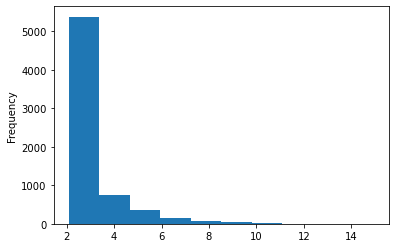

In [51]:
distances_df[distances_df["ac_helix"] == "in"]["17_24"].plot.hist()

<AxesSubplot:xlabel='17_24', ylabel='24_47'>

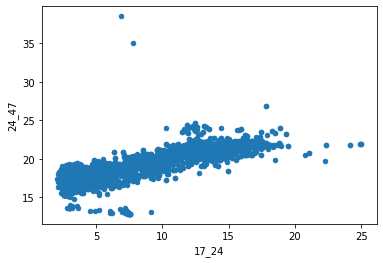

In [52]:
distances_df.plot.scatter("17_24", "24_47")

In [60]:
salt_bridge_statistics = []
for critical_distance in critical_distances:
    row = []
    row.append(distances_df[distances_df["17_24"] <= 3][critical_distance].mean())
    row.append(distances_df[distances_df["17_24"] <= 3][critical_distance].std())
    row.append(distances_df[distances_df["17_24"] > 10][critical_distance].mean())
    row.append(distances_df[distances_df["17_24"] > 10][critical_distance].std())
    salt_bridge_statistics.append(row)
salt_bridge_statistics = salt_bridge_statistics = pd.DataFrame(salt_bridge_statistics)
salt_bridge_statistics.columns = ["in_mean", "in_std", "out_mean", "out_std"]
salt_bridge_statistics.index = critical_distances
salt_bridge_statistics

,in_mean,in_std,out_mean,out_std
17_24,2.740827,0.131068,14.146603,2.188693
20_49,26.400868,2.131793,30.650660,1.417065
22_48,22.677562,1.018469,23.935321,1.138413
24_47,17.391289,0.663375,21.340958,0.958528
26_46,16.573876,0.740817,16.137563,1.251457
28_45,9.717440,0.538373,11.249257,0.967244
